# Implement the Direct Linear Transform (DLT) algorithm (16 Points)

In [124]:
import numpy as np
from utils._dlt_utils import load_given, plot_2dpointclouds, add_noise, is_rot_mat
import matplotlib.pyplot as plt

# Loading Data
We first load the 3D pointcloud and the corresponding 2D point cloud, as well as the intrinsics $\mathbf K$.

In [125]:
p3d, p2d, K = load_given()

# Helper Functions (2 Points)
Write helper functions to homogenize points, and calibrate the 2d points such that we can w.l.o.g. assume that the camera is calibrated.
`homogenize` takes n dimensional points and returns them in homogeneous coordinates. `calibrate` takes 2D points and the camera intrinsics, and returns the calibrated 2D points (see theoretical exercise (a)).

In [126]:
def homogenize(points):
    """
        Convert nD points to (n+1)D homogeneous coordinates.
        
        Args:
            points (np.ndarray): points of shape (N, n).
        Returns:
            np.ndarray: homogeneous coordinates of shape (N, n+1).
    """
    return np.hstack((points, np.ones((points.shape[0], 1))))

def calibrate(points_2d, K):
    """
        Transform 2D points from into calibrated coordinates (i.e. as if K = I).
        
        Args:
            points_2d (np.ndarray): 2D points of shape (N, 2).
            K (np.ndarray): camera intrinsic matrix of shape (3, 3).
        Returns:
            np.ndarray: calibrated 2D points of shape (N, 3).
    """
    return np.linalg.solve(K, homogenize(points_2d).T).T

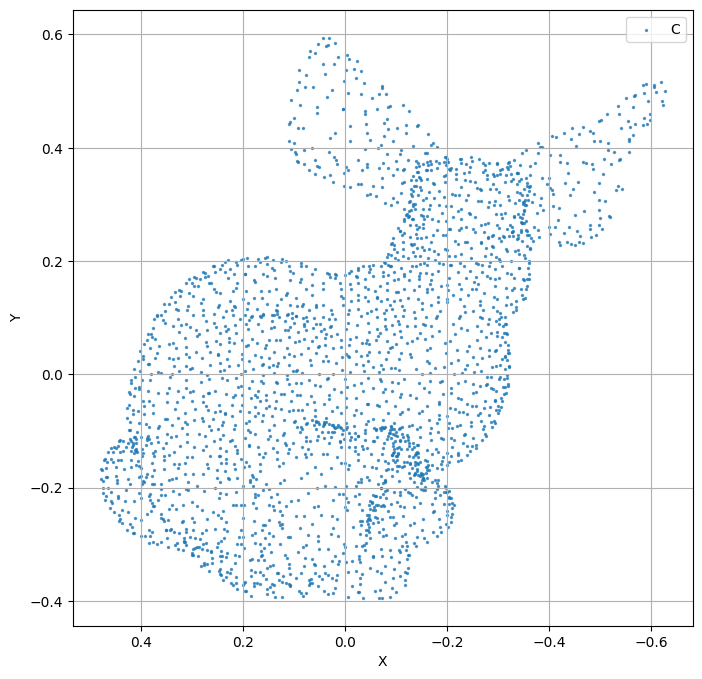

In [127]:
cal_p2d = calibrate(p2d, K)
# We can plot the calibrated 2D points. The ranges should be between [-1, 1].
plot_2dpointclouds(cal_p2d, "Calibrated 2D points")

# Setting up the linear system (6 Points)
In exercise (b) and (c) you have set up a matrix $\mathbf M$ such that the solution to the linear system $\mathbf M \mathbf \theta = \mathbf 0$ can be used to estimate the camera pose. Write the function `setup_linear_system` which takes the 3D points, the 2D points as input and returns the matrix $\mathbf M$.

In [128]:
def setup_linear_system(p3d, p2d):
    """
        Create the matrix M for the linear system M \theta = 0 from exercise (b).
        
        Args:
            p3d: Nx3 array of 3D points
            p2d: Nx2 array of 2D points
            
        Returns:
            M: Dx12 array describing the linear system
    """ 
    N = p3d.shape[0]
    M = np.zeros((2*N, 12))
    
    for i in range(N):
        x, y, z = p3d[i]
        u, v, _ = p2d[i]
        
        M[2*i] = [x, y, z, 1, 0, 0, 0, 0, -u*x, -u*y, -u*z, -u]
        M[2*i + 1] = [0, 0, 0, 0, x, y, z, 1, -v*x, -v*y, -v*z, -v]
    
    return M

In [129]:
M = setup_linear_system(p3d, cal_p2d)

# Solving in the least squares sense (2 Points)
We are working with more points than necessary for the linear system to be solvable, because we are more interested in a solution that is robust to noise. Use the SVD to solve the linear system in the least squares sense (exercise (d)). The function `solve_linear_system` takes the matrix $\mathbf M$ and returns the solution $\mathbf \theta$.

In [130]:
def solve_least_squares(M):
    """
        Solve the linear system M \theta = 0 in the least squares sense.
        
        Args:
            M: Dx12 array describing the linear system
            
        Returns:
            theta: 12 array containing the solution
    """
    # Compute M^T M
    MTM = M.T @ M
    
    # Find eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(MTM)
    
    # Find the index of the smallest eigenvalue
    min_eigenvalue_idx = np.argmin(eigenvalues)
    # The solution is the eigenvector corresponding to the smallest eigenvalue
    theta = eigenvectors.T[:, min_eigenvalue_idx]
    
    # Ensure real values (sometimes we get complex numbers with tiny imaginary parts)
    theta = np.real(theta)
    
    return theta

In [131]:
theta = solve_least_squares(M)
print(theta)

[-1.57271680e-03 -2.99278319e-04  3.43289364e-03  1.67530973e-02
  3.44046869e-02  6.72666476e-02 -2.62093443e-02 -2.10958592e-02
  3.70363622e-01 -4.80196249e-01 -4.33910859e-01  6.60929839e-01]


# Extracting the camera pose (4 Points)
Use your approach from exercise (e) to extract the camera pose from the solution $\mathbf \theta$. The function `extract_camera_pose` takes the solution $\mathbf \theta$ and returns the camera pose in the form of a rotation matrix $\mathbf R$ and a translation vector $\mathbf t$. Make sure that your rotation matrix is orthogonal and has determinant 1. This is checked by the is_rot_mat function that is provided.

In [132]:
def extract_extrinsics(theta):
    """
        Extract the extrinsics R and t from the solution theta.
        
        Args:
            theta: 12 normalized array
            
        Returns:
            R: 3x3 rotation matrix
            t: 3x1 translation vector
    """
    # Reshape theta into 3x4 projection matrix P
    P = theta.reshape(3, 4)
    
    # Extract the first 3 columns as R and the last column as t
    R = P[:, :3]
    t = P[:, 3].reshape(3, 1)
    
    # Ensure R is a proper rotation matrix by using SVD
    U, _, Vt = np.linalg.svd(R)
    R = U @ Vt
    
    # Ensure determinant is +1
    if np.linalg.det(R) < 0:
        R = -R
    
    return R, t

In [133]:
R, t = extract_extrinsics(theta)
is_rot_mat(R) # Check if R is a valid rotation matrix
print("R:\n", R)
print("t:\n", t)

R is a valid rotation matrix
R:
 [[-0.68992854  0.10907039 -0.71561321]
 [-0.51761265 -0.76542025  0.38237284]
 [-0.50603928  0.63422038  0.58454149]]
t:
 [[ 0.0167531 ]
 [-0.02109586]
 [ 0.66092984]]


# Visualize the result (1 Points)

These are our estimates for the extrinsic parameters. Let us see how the 3D points are projected onto the image plane using these parameters. We will use the `reproject` function for this. Note that the reproject function does not assume a calibrated camera, and therefore takes $\mathbf K$ as an argument. We will compare the resulting 2D points with the original 2D points before the calibration step.

In [134]:
def reproject(p3d, R, t, K):
    """
        Reproject 3D points to 2D using the extrinsics R and t.
        
        Args:
            p3d: Nx3 array of 3D points
            R: 3x3 rotation matrix
            t: 3x1 translation vector
            K: 3x3 intrinsic matrix
            
        Returns:
            p2d: Nx2 array of 2D points
    """
    # Convert 3D points to homogeneous coordinates (Nx4)
    p3d_homo = homogenize(p3d)
    
    # Create the projection matrix P = K[R|t]
    Rt = np.hstack((R, t))  # 3x4 matrix
    P = K @ Rt  # 3x4 projection matrix
    
    # Project points
    p2d_homo = (P @ p3d_homo.T).T
    
    # Convert from homogeneous to 2D coordinates
    p2d = p2d_homo[:, :2] / p2d_homo[:, 2:]
    
    return p2d


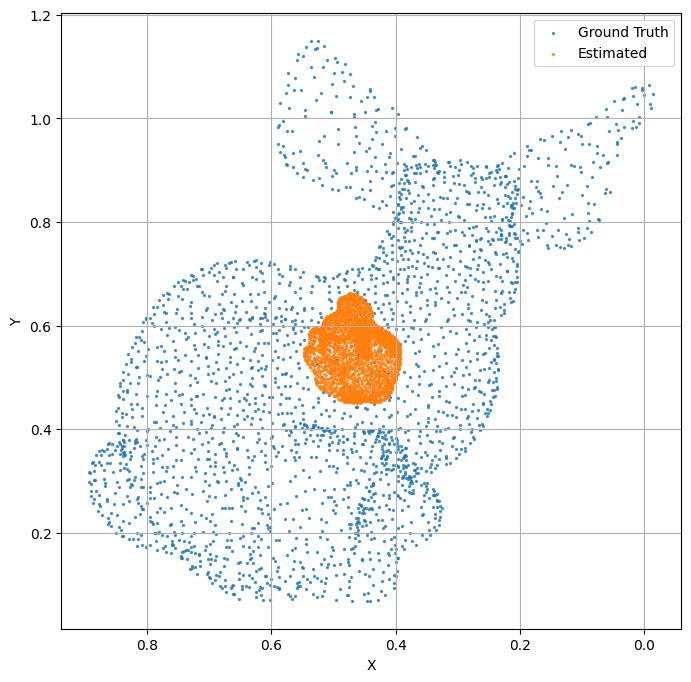

In [135]:
estimated_2d_points = reproject(p3d, R, t, K)
plot_2dpointclouds([p2d, estimated_2d_points], ["Ground Truth", "Estimated"])

# Reprojection Error (1 Points)
Finally, we want to compute the reprojection error. The mean reprojection error is defined as
$$
    E = \frac{1}{N} \sum \limits_{i=1}^{N} \| \mathbf{p}_i - \mathbf{p}_i^{\prime} \|
$$
where $\mathbf{p}_i$ is the original 2D point and $\mathbf{p}_i^{\prime}$ is the reprojected 2D point given the estimated camera pose. It measures the average offset of image points, measured in pixels.

Fill in the missing code in the following cell to compute the reprojection error given the two 2D point clouds.

In [136]:
def reprojection_error(p2d, estimated_p2d):
    """
        Compute the reprojection error of the estimated extrinsics.
        
        Args:
            p2d: Nx2 array of ground_truth 2D points
            estimated_p2d: Nx2 array of estimated 2D points
            
        Returns:
            error: reprojection error in pixels
    """
    # Compute the squared differences for each coordinate
    diff = p2d - estimated_p2d
    
    # Compute the squared Euclidean distance for each point
    squared_distances = np.sum(diff**2, axis=1) ** 0.5
    
    # Compute the mean squared error
    return np.mean(squared_distances)

In [137]:
error = reprojection_error(p2d, estimated_2d_points)
print(error)

0.2883311617846379
